In [ ]:
# 구글 드라이브 연결

from google.colab import drive
import shutil
import os

drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/examples/2장/data'
os.makedirs(project_path, exist_ok=True)

# 현재 경로를 /content/drive로 설정
os.chdir(project_path)
print("현재 작업 디렉토리:", os.getcwd())
os.listdir(project_path)

Mounted at /content/drive
현재 작업 디렉토리: /content/drive/MyDrive/ch2


['dance.mov', 'heart_rgb.png', 'heart_gray.png', 'heart.png', 'sudoku.jpeg']

In [ ]:
os.listdir(project_path)

['dance.mov', 'heart_rgb.png', 'heart_gray.png', 'heart.png', 'sudoku.jpeg']

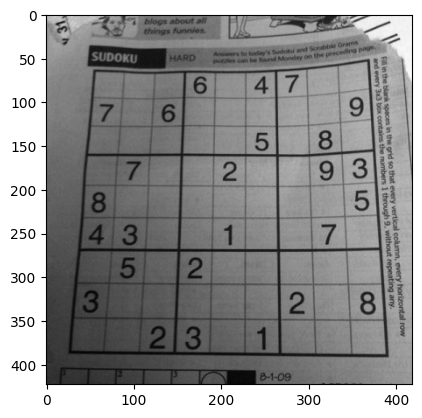

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = os.path.join(project_path, 'sudoku.jpeg')
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

In [ ]:
def preprocess_image(image):
    # 그레이스케일로 이미지 로드
    # 가우시안 블러 적용
    blur = cv2.GaussianBlur(image, (9, 9), 0)
    # 적응형 이진화
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    return thresh

def find_largest_polygon(thresh):
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest = None
    max_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
            if area > max_area and len(approx) == 4:
                largest = approx
                max_area = area
    return largest

def extract_sudoku(image, corners):
    corners = corners.reshape((4, 2))
    sorted_corners = np.zeros((4, 2), dtype=np.float32)

    s = corners.sum(axis=1)
    sorted_corners[0] = corners[np.argmin(s)]
    sorted_corners[2] = corners[np.argmax(s)]

    diff = np.diff(corners, axis=1)
    sorted_corners[1] = corners[np.argmin(diff)]
    sorted_corners[3] = corners[np.argmax(diff)]

    side = max([
        np.linalg.norm(sorted_corners[0] - sorted_corners[1]),
        np.linalg.norm(sorted_corners[1] - sorted_corners[2]),
        np.linalg.norm(sorted_corners[2] - sorted_corners[3]),
        np.linalg.norm(sorted_corners[3] - sorted_corners[0])
    ])

    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(sorted_corners, dst)
    extracted = cv2.warpPerspective(image, matrix, (int(side), int(side)))
    return extracted

proc_img = preprocess_image(img)
largest_polygon = find_largest_polygon(proc_img)
aff_img = extract_sudoku(proc_img, largest_polygon)

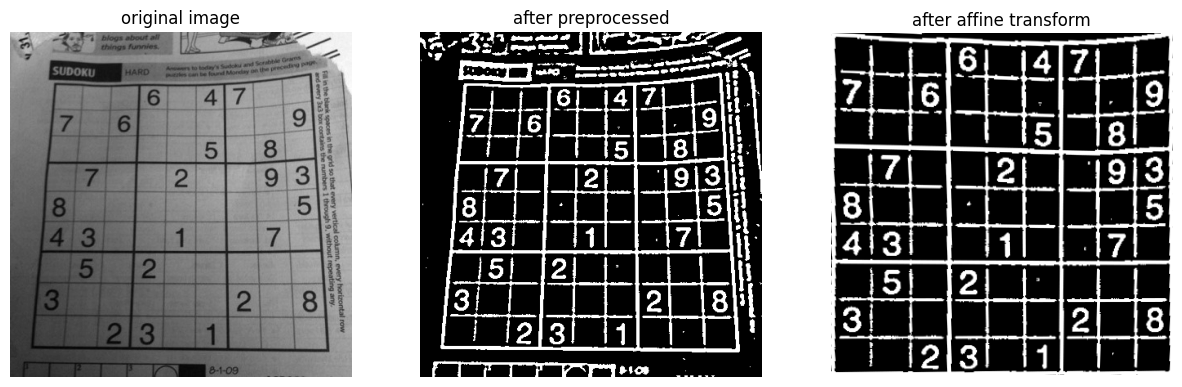

In [ ]:
# 이미지 시각화
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('original image')
axs[0].axis('off')

axs[1].imshow(proc_img, cmap='gray')
axs[1].set_title('after preprocessed')
axs[1].axis('off')

axs[2].imshow(aff_img, cmap='gray')
axs[2].set_title('after affine transform')
axs[2].axis('off')

plt.show()